  * https://www.kaggle.com/viridisquotient/arimax
  * Lhttps://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [23]:
import data_prep_helper
import statsmodels.api as sm
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [25]:
do = data_prep_helper.ShiftChartData(chart_col=["Price","High","Low"])

In [26]:
corr_df = do.chart_df


In [27]:
corr_df = corr_df.resample('D').interpolate()

In [71]:
#creating the train and validation set
train = corr_df[:1500]
valid = corr_df[1500:]

In [72]:
train = do.get_causal_const_shift(train)

In [73]:
valid = do.get_causal_const_shift(valid)

In [65]:
train["economy_pos_sents_prev_month"] = train["economy_pos_sents_prev_month"].rolling(window=10,min_periods=1).mean()
valid["economy_pos_sents_prev_month"] = valid["economy_pos_sents_prev_month"].rolling(window=10,min_periods=1).mean()


In [74]:
%%time
s1i1 = train['bitcoin_Price']
exog_s1i1 = train[['bitcoin_Google_Trends_prev_month',
                  'cryptocurrency_Google_Trends_prev_month',
                  'alibaba_High_prev_month',
                  'amazon_High_prev_month',
                  'economy_pos_sents_prev_month']].fillna(0)
    

arimax = sm.tsa.statespace.SARIMAX(s1i1, exog=exog_s1i1,
                                   enforce_invertibility=False, enforce_stationarity=False, freq='D').fit()
print(arimax.summary())

                               SARIMAX Results                                
Dep. Variable:          bitcoin_Price   No. Observations:                 1469
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -11600.702
Date:                Fri, 10 Apr 2020   AIC                          23215.404
Time:                        19:06:12   BIC                          23252.445
Sample:                    02-08-2015   HQIC                         23229.218
                         - 02-15-2019                                         
Covariance Type:                  opg                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
bitcoin_Google_Trends_prev_month           -0.2126      0.159     -1.338      0.181      -0.524       0.099
cryptocurrency_Google_Trends_prev_month     

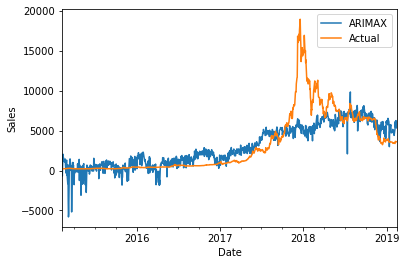

In [75]:


exog = train[['bitcoin_Google_Trends_prev_month',
                  'cryptocurrency_Google_Trends_prev_month',
                  'alibaba_High_prev_month',
                  'amazon_High_prev_month',
                  'economy_pos_sents_prev_month']].fillna(0)
forecast =  arimax.predict( dynamic=True, exog=exog)
actual = train["bitcoin_Price"]

forecast.plot()
actual.plot()
plt.legend(['ARIMAX', 'Actual'])
plt.ylabel('Sales');



In [76]:
exog = valid[['bitcoin_Google_Trends_prev_month',
                  'cryptocurrency_Google_Trends_prev_month',
                  'alibaba_High_prev_month',
                  'amazon_High_prev_month',
                  'economy_pos_sents_prev_month']].fillna(0)

In [77]:
forecast = arimax.get_forecast(steps=len(valid), exog=exog)

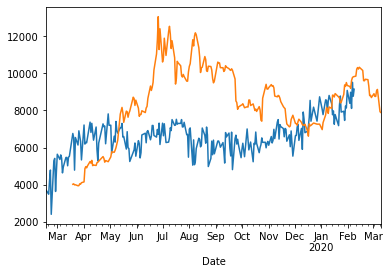

In [78]:
forecast.predicted_mean.plot()
valid["bitcoin_Price"].plot()

In [79]:
sqrt(mean_squared_error(forecast.predicted_mean, valid["bitcoin_Price"]))

2613.3169663012336

In [80]:
arimax.save("models/sarimax_5_feat_month.pkl")